# Tweaking CNNs for real world data

Here, we will attempt all three notebooks in our way for understanding concepts better

## Notebook 1

### Fetching data

In [1]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2023-12-27 08:44:25--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.119.184.235, 2600:1407:a800:2a0::317f, 2600:1407:a800:28d::317f
Connecting to download.microsoft.com (download.microsoft.com)|104.119.184.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  55.4MB/s    in 13s     

2023-12-27 08:44:38 (62.7 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [2]:
! unzip ./kagglecatsanddogs_5340.zip -d ./cat-or-dog

Streaming output truncated to the last 5000 lines.
  inflating: ./cat-or-dog/PetImages/Dog/5500.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5501.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5502.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5503.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5504.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5505.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5506.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5507.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5508.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5509.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/551.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5510.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5511.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5512.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5513.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5514.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5515.jpg  
  inflating: ./cat-or-dog/PetImages/Dog/5516.jpg  
  inflating: ./cat-or-dog/PetIma

Checking the data

In [3]:
import os

CATS_PATH = './cat-or-dog/PetImages/Cat'
DOGS_PATH = './cat-or-dog/PetImages/Dog'

cats = os.listdir(CATS_PATH)
dogs = os.listdir(DOGS_PATH)

print(type(cats), len(cats))
print(type(dogs), len(dogs))

<class 'list'> 12501
<class 'list'> 12501


### Data Preprocessing

Plotting the data images

['4640.jpg', '6754.jpg', '9791.jpg', '6058.jpg', '11565.jpg', '6491.jpg', '8937.jpg', '2901.jpg', '8969.jpg', '2127.jpg']


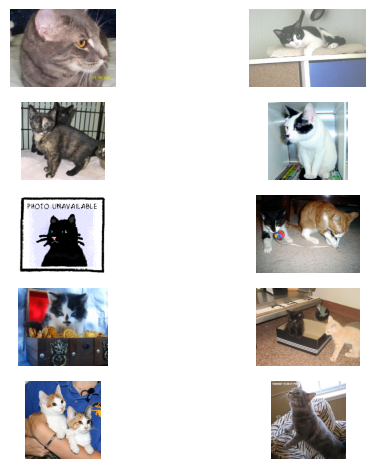

In [4]:
%matplotlib inline
from random import randint
import matplotlib.pyplot as plt
from skimage import io

indx = randint(0, len(cats))
cat_array = cats[indx:indx+10]
print(cat_array)
fig, axes = plt.subplots(5,2)

for i, ax in enumerate(axes.flat):
    img = io.imread(os.path.join(CATS_PATH, cat_array[i]))
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

['9618.jpg', '8708.jpg', '1249.jpg', '5360.jpg', '8404.jpg', '10625.jpg', '5461.jpg', '6346.jpg', '12427.jpg', '1975.jpg']


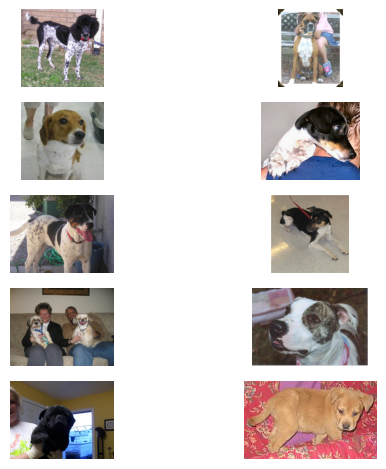

In [5]:
%matplotlib inline

indx = randint(0,len(dogs))
dog_array = dogs[indx : indx+10]

print(dog_array)

fig, axes = plt.subplots(5,2)
for i, ax in enumerate(axes.flat):
    img = io.imread(os.path.join(DOGS_PATH,dog_array[i]))
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Removing Corrupt image files

In [24]:
import os
import PIL.Image

def remove_corrupt_images(dataset_path):
  """Removes corrupt image files from a dataset.

  Args:
    dataset_path: The path to the dataset.

  Returns:
    A dictionary with the valid image files.
  """

  dataset = {}
  for filename in os.listdir(dataset_path):
    image_path = os.path.join(dataset_path, filename)
    try:
      image = PIL.Image.open(image_path)
      dataset[filename] = image
    except PIL.UnidentifiedImageError:
      print("Corrupt image file:", image_path)

  return dataset

dataset = remove_corrupt_images("/content/cat-or-dog/PetImages/Dog")

Corrupt image file: /content/cat-or-dog/PetImages/Dog/Thumbs.db


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupt image file: /content/cat-or-dog/PetImages/Dog/11702.jpg


In [25]:
samp_img = io.imread('/content/cat-or-dog/PetImages/Dog/11702.jpg')
plt.imshow(samp_img)

AttributeError: ignored

In [26]:
! rm /content/cat-or-dog/PetImages/Dog/Thumbs.db

In [27]:
! rm /content/cat-or-dog/PetImages/Dog/11702.jpg

### Creating dataset generator object

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
# Divides each pixel value by 255, so as to normalize it between 0 and 1
data_gen = ImageDataGenerator(
    rescale=(1/255),
    validation_split=0.3
)

train_generator = data_gen.flow_from_directory(
    './cat-or-dog/PetImages/',
    target_size=(512,512),
    batch_size=128,
    class_mode='binary',
    subset='training'
)

Found 17500 images belonging to 2 classes.


### Model Declaration

In [30]:
import tensorflow as tf
import numpy as np

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),input_shape=(512,512,3) , activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 510, 510, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 255, 255, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 253, 253, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 126, 126, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)       

In [33]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Training

In [34]:
history = model.fit(
    train_generator,
    steps_per_epoch=128,
    epochs=15,
    verbose=1
)

Epoch 1/15
 62/128 [=============>................] - ETA: 1:18 - loss: 0.6996 - accuracy: 0.5082

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


128/128 [==============================] - 166s 1s/step - loss: 0.6952 - accuracy: 0.5254
Epoch 2/15
128/128 [==============================] - 152s 1s/step - loss: 0.6385 - accuracy: 0.6367
Epoch 3/15
128/128 [==============================] - 172s 1s/step - loss: 0.5794 - accuracy: 0.6908
Epoch 4/15
128/128 [==============================] - 178s 1s/step - loss: 0.5314 - accuracy: 0.7302
Epoch 5/15
128/128 [==============================] - 156s 1s/step - loss: 0.4957 - accuracy: 0.7573
Epoch 6/15
128/128 [==============================] - 153s 1s/step - loss: 0.4428 - accuracy: 0.7947
Epoch 7/15
128/128 [==============================] - 152s 1s/step - loss: 0.4044 - accuracy: 0.8197
Epoch 8/15
128/128 [==============================] - 151s 1s/step - loss: 0.3450 - accuracy: 0.8495
Epoch 9/15
128/128 [==============================] - 152s 1s/step - loss: 0.2773 - accuracy: 0.8860
Epoch 10/15
128/128 [==============================] - 152s 1s/step - loss: 0.2074 - accuracy: 0.9171


{'loss': [0.6952333450317383, 0.6384531259536743, 0.5793889164924622, 0.5314428210258484, 0.4957295060157776, 0.44279274344444275, 0.40443333983421326, 0.3449726700782776, 0.27732717990875244, 0.2073535919189453, 0.1564960479736328, 0.11125532537698746, 0.1315113604068756, 0.17279736697673798, 0.07307017594575882], 'accuracy': [0.5254465341567993, 0.6366528272628784, 0.6908490061759949, 0.7302422523498535, 0.7572791576385498, 0.7946537733078003, 0.8196721076965332, 0.8495228886604309, 0.88604736328125, 0.9170540571212769, 0.9447027444839478, 0.9650110006332397, 0.9710667729377747, 0.9735747575759888, 0.9815879464149475]}


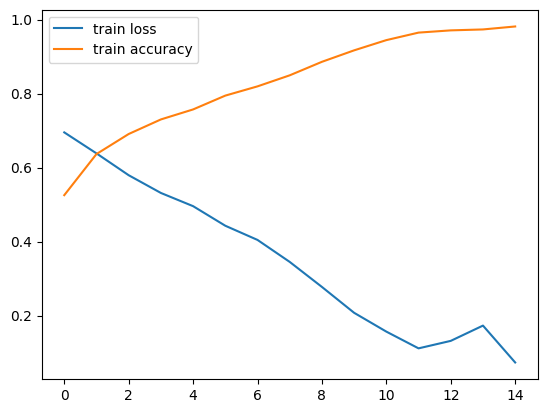

In [71]:
train_plot_data = history.history
print(train_plot_data)

plt.plot(train_plot_data['loss'], label='train loss')
plt.plot(train_plot_data['accuracy'], label='train accuracy')
plt.legend()

### Checking on Validation dataset

In [40]:
validation_generator = data_gen.flow_from_directory(
    './cat-or-dog/PetImages/',
    batch_size=128,
    target_size=(512,512),
    class_mode='binary',
    subset='validation'
)

Found 7498 images belonging to 2 classes.


In [41]:
val_history = model.evaluate(validation_generator)

59/59 [==============================] - 66s 1s/step - loss: 0.7387 - accuracy: 0.8241


### Check random image

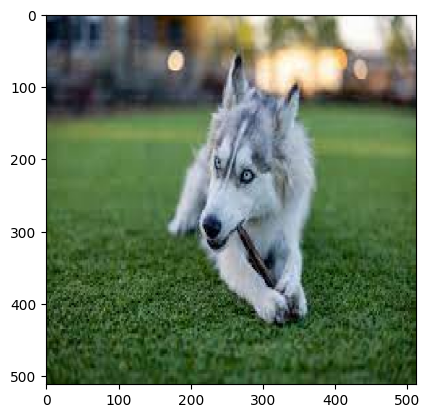

In [60]:
from tensorflow.keras.utils import load_img, img_to_array

samp_img = load_img('/content/random/dog1.jpeg', target_size=(512,512,3))
samp_img = img_to_array(samp_img) / 255
plt.imshow(samp_img)

In [61]:
print(train_generator.class_indices)
samp_img = samp_img.reshape(1,512,512,3)
output = model.predict(samp_img)

if output[0] > 0.5:
  print('It is a Dog')
else:
  print('It is a Cat')

{'Cat': 0, 'Dog': 1}
1/1 [==============================] - 0s 20ms/step
It is a Dog
